<a href="https://colab.research.google.com/github/Vildend/tf-data-analysis-project2/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%20%D0%B2%20%D0%B8%D0%BD%D0%B4%D1%83%D1%81%D1%82%D1%80%D0%B8%D0%B8.%20%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%202.%20%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import plotly.express as px

from scipy.stats import norm

# from google.colab import files
# uploaded = files.upload()

------------------

**Описание данных**

Процесс оформления кредитной карты (КК) устроен следующим образом:
1.   человек заходит на сайт и заполняет информацию о себе (в том числе возраст и доход клиента) для получения кредитной карты;
2.   человек проходит скоринг (в том числе в рамках которого оценивается вероятность банкротства клиента)
3.  создаётся заявка на оформление кредитной карты
4.  человеку выпускается виртуальная карта, а также предлагается наша услуга к этому счёту
5.  с некоторой вероятностью человек утилизирует счёт (начинает им пользоваться)
6.  если человек не утилизирует счёт, мы несём некоторые затраты на время оператора и поддержку инфраструктуры
7.  если человек утилизировал карту, мы имеем некоторый заработок (PV) и повышенные расходы.

**Описание колонок в исторических данных.**


*   *ID* - номер заявки, прошедшей скоринг
*   *Возраст* - возраст клиента, указанный при оформлении КК
*   *Доход клиента* - доход клиента, указанный при оформлении КК
*   *Вероятность банкротства* - оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента
*   *Флаг утилизация счёта* - совершение первой расходной операции на счёте КК
*   *Расходы* - сумма затрат на заявку
*   *PV КК* - 0 если счёт не утилизирован, иначе = PV кредитной карты
*   *PV услуги* - 0 если счёт не утилизирован, иначе = PV этой услуги
*   *NPV* = PV КК + PV услуги - Расходы


### 0. Запросить у бота в Телеграме условие командой `/get_project2_desc`.

В этом задании вам предстоит провести A/B тест на процессе оформления кредитных карт.

**Контекст**

Мы провели Cust Dev и поняли, что форма авторизации для клиента сложна, и из-за этого часть клиентов отваливается в заявочном процессе. Мы решили разработать новый процесс авторизации, и у нас есть гипотеза, что он позволит повысить утилизации наших счетов.
        
**Тест**

Мы проводим тест, в рамках которого мы разбиваем весь поток на две части рановероятно, где у одной части (контроля) старый процесс авторизации, а у второй части (теста) - новый. Целью этого теста является повышение утилизаций счёта.

**Статистические вводные**

Проверка однородности выбранного параметра осуществяется с уровнем значимости 2%. Уровень значимости 5%. Мы хотели бы различать 3%-ное изменение целевой метрики с вероятностью 95%.

**Нулевая гипотеза**: количество утилизаций счета при новом процессе авторизации не повышается

**Альтернативная гипотеза**: при новом процессе авторизации, количество утилизаций счета повышается

In [38]:
df = pd.read_csv('hist_credit_card.csv')
df.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


In [39]:
px.histogram(df['Флаг утилизации счёта'])

### 1. Необходимо выбрать метрику и привести аргументацию.

Целью этого теста является повышение утилизаций счёта, следовательно, в качестве целевой метрики мы выбираем **долю утилизаций счета**.

### 2. Альтернатива в критерии.

Мы будем рассматривать левостороннюю альтернативу, так как нас интерсует повышение утилизаций счёта.

### 3. Нужно выбрать параметр(-ы), влияющий(-ие) на целевую метрику. Привести аргументацию.

In [40]:
df.corr()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
ID,1.000000,-0.002624,0.004518,0.001279,-0.000964,-0.000077,-0.003181,-0.005220,-0.003480
Возраст,-0.002624,1.000000,0.001514,-0.004102,0.007277,0.002460,0.003447,0.006117,0.003747
Доход клиента,0.004518,0.001514,1.000000,-0.000882,0.000706,0.001032,-0.002142,-0.001937,-0.002269
Вероятность банкротства,0.001279,-0.004102,-0.000882,1.000000,-0.215398,-0.099635,-0.043319,-0.139128,-0.049433
Флаг утилизации счёта,-0.000964,0.007277,0.000706,-0.215398,1.000000,0.452036,0.204981,0.646524,0.233611
Расходы,-0.000077,0.002460,0.001032,-0.099635,0.452036,1.000000,0.090826,0.294538,0.086146
PV КК,-0.003181,0.003447,-0.002142,-0.043319,0.204981,0.090826,1.000000,0.128742,0.998232
PV услуги,-0.005220,0.006117,-0.001937,-0.139128,0.646524,0.294538,0.128742,1.000000,0.183529
NPV,-0.003480,0.003747,-0.002269,-0.049433,0.233611,0.086146,0.998232,0.183529,1.000000


❌ С флагом утилизации счёта наиболее коррелирует **возраст клиента**, в таком случае, мы будем рассматривать данную метрику в качестве влияющей на нашу целевую метрику. ❌


---

✅ В данном моменте я допустил ошибку. Параметр для проверки однородности нужно было выбирать из тех, что доступны до прохода человека по процессу заявки. Я невнимательно прочитал описание данных, где говорилось, что в параметры скоринга также входит "Вероятность банкротства". В таком случае, для нашей целевой метрики наиболее влияет **вероятность банкротства**, её я и возьму далее. ✅

### 4.1. Каков размер выборки? Привести аргументацию и написать как получилось то или иное число.

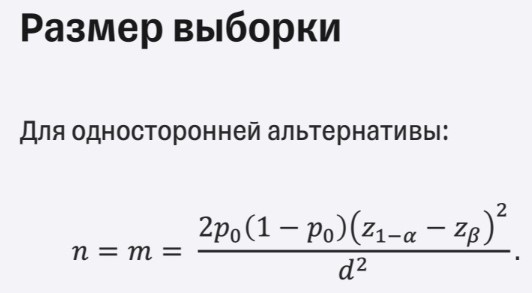

Мы хотели бы различать 3%-ное изменение целевой метрики, поэтому найдем MDE:

In [41]:
MDE = df['Флаг утилизации счёта'].mean() * 0.03
MDE

0.02224631860776439

Теперь укажем p0, alpha и betta, а затем найдем размер выборки.

In [42]:
p = df['Флаг утилизации счёта'].value_counts(normalize = True)[1]
alpha = 0.05
betta = 0.05

In [43]:
sample_size = ( 2 * p * (1 - p) * (norm.ppf(1 - alpha) - norm.ppf(betta)) ** 2 ) / (MDE ** 2)
np.ceil(sample_size)

8383.0

### 4.2. Необходимо запросить у бота в Телеграме выборку полученного размера командой `/get_project2_sample {размер выборки}` и вписать <ins>код выборки</ins>:

In [44]:
# Код выборки
68335

68335

In [45]:
df_control = pd.read_csv('Контроль.csv')
df_test    = pd.read_csv('Тест.csv')

df_control

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,26,30118.619648,0.024275,1,396,10004,4451,14059
1,1,75,36013.784105,0.069509,1,60,11759,1486,13185
2,2,70,30608.778367,0.132728,1,818,7078,2858,9118
3,3,31,20102.094038,0.055883,0,1,0,0,-1
4,4,46,27895.471358,0.043114,1,308,18316,1422,19430
...,...,...,...,...,...,...,...,...,...
8378,8378,68,20522.339219,0.461081,0,21,0,0,-21
8379,8379,31,35896.759547,0.072692,1,763,5526,1660,6423
8380,8380,46,23715.400769,0.144956,1,528,6264,1529,7265
8381,8381,46,30873.908915,0.023449,1,286,9378,2689,11781


### 5. Проверка на однородность, применение критерия. Принятие решения. Расписать подробно с аргументами.

Проверим однородность выборок нашего параметра (вероятность банкротства), влияющего на целевую метрику (флаг утилизации счёта). Так как мы хотим проверить однородность распределений, то воспользуемся критерием anderson_ksamp. Проверку однородности выбранного параметра осуществяем с уровнем значимости 2%.

In [46]:
from scipy.stats import anderson_ksamp

anderson_pvalue = anderson_ksamp([df_control['Вероятность банкротства'], df_test['Вероятность банкротства']]).pvalue
anderson_pvalue

<ipython-input-46-108248c34f21>:3: UserWarning:

p-value capped: true value larger than 0.25



0.25

In [47]:
anderson_pvalue < 0.02

False

Получаем, что наше pvalue не меньше установленного уровня значимости, следовательно выборки **однородны**. В таком случае, применим критерий для целевой метрики. Будем использовать критерий proportions_ztest, так как мы имеем дело с бинарным распределением.

In [48]:
from statsmodels.stats.proportion import proportions_ztest

stat, pval = proportions_ztest([df_control['Флаг утилизации счёта'].value_counts()[1], df_test['Флаг утилизации счёта'].value_counts()[1]], [sample_size, sample_size], alternative = 'smaller')

pval

3.744065732162241e-05

In [49]:
pval < alpha

True

Наше полученное pvalue **меньше** установленного alpha, поэтому мы можем отклонить нулевую гипотезу. Отсюда мы можем сделать вывод, что при новом процессе авторизации количество утилизаций счета действительно повышается.